In [1]:
import os, sys
sys.path.append('./src')

import numpy as np

import torch
import torch.nn as nn
from torchmetrics.functional import accuracy, f1_score

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

# parameters and annotation 
from dataclasses import dataclass, field
from typing import Dict

# Data Visualization
import pyvista as pv        
import pyvistaqt as pvqt
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import (
    display,
    clear_output,
    HTML
)

# Logs
from prettytable import PrettyTable
# tensorboard? w&b? 

# Data Management
import h5py 
from src.data_preprocessing.dataset import MVDataset
from src.data_preprocessing.data_module import MVDataModule

# GATr layers: 
from src.GA_layers.Linears import (EquiLinear, Bilinear)                  
from src.GA_layers.Activatons import EquiGeLU
from src.GA_layers.NormLayers import EquiNormLayer
from src.GA_layers.Attentions import EquiMultiHeadAttention

# GATr utils
import src.Utils.geometric_utility as GA_utility
from src.Utils.equivariance_check import equivariance_check

# Generic setting:
pv.set_jupyter_backend('trame')     # data visualization
pl.seed_everything(0)               # reproducibility

torch.set_float32_matmul_precision('medium')
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

Seed set to 0


In [2]:
model_table = PrettyTable()
model_table.field_names = ["Model", "f1_train", "f1_test", "params numb", "equivariance", "epochs req"]


# Intro, Data Analysis
- sub-section 1<br> 
 the next session of the notebook present the dataset,
 our task and analize the statistc of the dataset. 
- sub-section 2<br>
 It will also present the strategy of downsample of the dataset

In [3]:
path = 'datasets/test'
# path = 'datasets/original_datasets
dataset = MVDataset()
# this contains raw data at the moment
dataset.load_data_files([os.path.join(path, file) for file in os.listdir(path) if file.endswith('.hdf5')])

In [5]:
def render_sample(id: int):
    """render one sample of the dataset"""

        
    face = dataset.X[id]['face'].numpy()
    pos = dataset.X[id]['pos'].numpy()


    triangles = (np.ones(face.shape[0], dtype=np.int32)*3).reshape(-1, 1)

    face_mesh = np.concatenate((triangles, face), axis=-1)
    face_mesh = face_mesh
    colors = torch.ones(pos.shape[0], 3)
    colors[dataset.X[id]['inlet_idcs']] = 0

    mesh = pv.PolyData(pos, face_mesh)
    mesh.point_data['inlet'] = colors
    plotter = pv.Plotter(notebook=True)
    plotter.add_mesh(mesh, scalars='inlet', show_edges=True)
    plotter.show(auto_close=True)

def callback(id):
    clear_output()
    display(input_box, button)
    render_sample(input_box.value)

#description_html = HTML("<p><b>Sample Visualization:</b> Select a sample ID and click 'Render' to visualize it." +
#                        "<br>The rendering is interactive, you can zoom in/out and rotate the view" +
#                        "<br><code>[Under 2000 are single, then bifurcating]<code></p>")
input_box = widgets.IntText(value=10, description='', min=0, max=dataset.__len__()-1)
button = widgets.Button(description='Render')  

button.on_click(callback)
#display(description_html, input_box, button)
display(input_box, button)
render_sample(0)

IntText(value=10)

Button(description='Render', style=ButtonStyle())

Widget(value='<iframe src="http://localhost:39653/index.html?ui=P_0x7c725bfab160_3&reconnect=auto" class="pyvi…

In [6]:
def max_min_for_1D_labels(X:np.array, y:np.array):
    out_dict = {}
    unique_labels = np.unique(y)
    for label in unique_labels:
        idx = np.where(y==label)
        X_max = np.max(X[idx])
        X_min = np.min(X[idx])
        out_dict[label] = [X_max, X_min]
    return out_dict


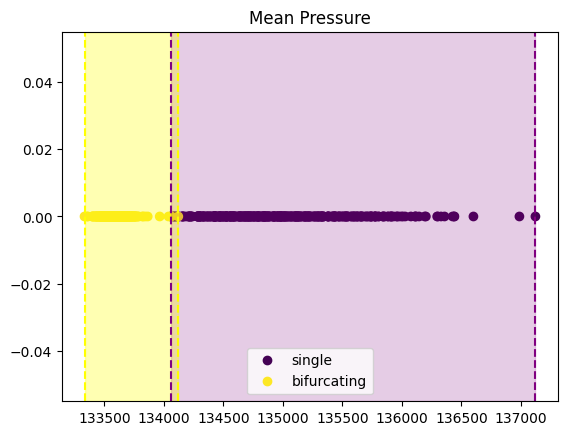

In [7]:
mean_pressure_X = []
mean_pressure_y = []
for i in range(dataset.__len__()):
    mean_pressure_X.append(dataset.X[i]['pressure'].mean().numpy())
    mean_pressure_y.append(dataset.y[i].numpy())

mean_pressure_X = np.array(mean_pressure_X)
mean_pressure_Y = np.array(mean_pressure_y)

scatter = plt.scatter(mean_pressure_X, np.zeros_like(mean_pressure_X), c=mean_pressure_Y)
handles, labels = scatter.legend_elements(prop="colors")
labels_dict = {0: 'single', 1: 'bifurcating'}  
plt.legend([handles[0], handles[1]], [labels_dict[0], labels_dict[1]])
plt.title("Mean Pressure")

min_max = max_min_for_1D_labels(mean_pressure_X, mean_pressure_Y)
plt.axvline(x=min_max[0][0], color='purple', linestyle='--')
plt.axvline(x=min_max[0][1], color='purple', linestyle='--')
plt.axvspan(min_max[0][0], min_max[0][1], color='purple', alpha=0.2)

plt.axvline(x=min_max[1][0], color='yellow', linestyle='--')
plt.axvline(x=min_max[1][1], color='yellow', linestyle='--')
plt.axvspan(min_max[1][0], min_max[1][1], color='yellow', alpha=0.3)



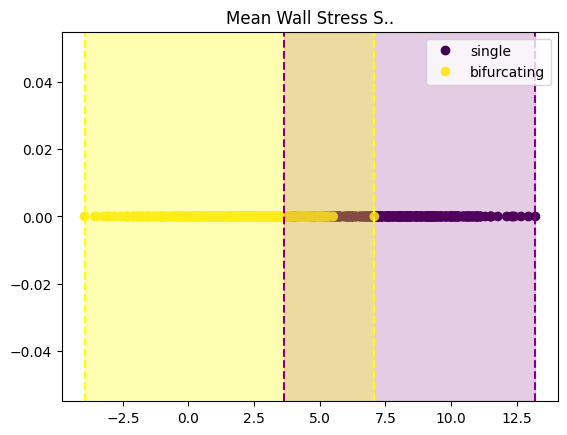

In [8]:
mean_wss_X, mean_wss_y = [], []
for i in range(dataset.__len__()):
    mean_wss_X.append(dataset.X[i]['wss'].mean().numpy())
    mean_wss_y.append(dataset.y[i].numpy())


mean_wss_X = np.array(mean_wss_X)
mean_wss_y = np.array(mean_wss_y)
    
scatter = plt.scatter(mean_wss_X, np.zeros_like(mean_wss_X), c=mean_wss_y)
handles, labels = scatter.legend_elements(prop="colors")
labels_dict = {0: 'single', 1: 'bifurcating'}  
plt.legend([handles[0], handles[1]], [labels_dict[0], labels_dict[1]])
plt.title("Mean Wall Stress S..")


min_max = max_min_for_1D_labels(mean_wss_X, mean_wss_y)
plt.axvline(x=min_max[0][0], color='purple', linestyle='--')
plt.axvline(x=min_max[0][1], color='purple', linestyle='--')
plt.axvspan(min_max[0][0], min_max[0][1], color='purple', alpha=0.2)

plt.axvline(x=min_max[1][0], color='yellow', linestyle='--')
plt.axvline(x=min_max[1][1], color='yellow', linestyle='--')
plt.axvspan(min_max[1][0], min_max[1][1], color='yellow', alpha=0.3)


# Dummy classifier for show how easy is to reconstruct the task

In [9]:


class DummyClassifier(torch.nn.Module):
    def __init__(self):
        super(DummyClassifier, self).__init__()
        self.L1 = torch.nn.Linear(2, 30)
        self.L2 = torch.nn.Linear(30, 1)
        self.act = torch.nn.ReLU()
    
    def forward(self, x):
        h = self.act(self.L1(x))
        return (self.L2(h))
    

model = DummyClassifier().to(device)
cross_entropy = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())
epochs = 15_000

Xy = torch.stack((
    torch.from_numpy(mean_pressure_X), 
    torch.from_numpy(mean_wss_X),
    torch.from_numpy(mean_wss_y)
    ),
    dim=-1).to(device)
Xy = Xy[torch.randperm(Xy.shape[0])]

train_size = int(0.8*Xy.shape[0])
Xy_train, Xy_test = Xy[:train_size, :], Xy[train_size:, :]


for epoch in range(epochs):
    Xy_train = Xy_train[torch.randperm(Xy_train.shape[0])]
    X, y = Xy_train[:, :2], Xy_train[:, 2]
    optimizer.zero_grad()
    y_hat = model(X).squeeze(-1)
    loss = cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()

y_hat_test = model(Xy_test[:, :2]).squeeze(-1)
y_hat_train = model(Xy_train[:, :2]).squeeze(-1)

acc_train = accuracy(y_hat_train, Xy_train[:, 2], task='binary')
acc_test = accuracy(y_hat_test, Xy_test[:, 2], task='binary')
print(f"accuracy: train = {acc_train}, test = {acc_test},")

f1_test = f1_score(y_hat_test, Xy_test[:, 2], task='binary')
f1_train = f1_score(y_hat_test, Xy_test[:, 2], task='binary')

model_table.add_row(["dummyMlp",           
              f1_train.item(),
              f1_test.item(),
              sum([p.numel() for p in model.parameters()]),
              "no",
              epochs])

print("\n\n", model_table)

accuracy: train = 0.9671875238418579, test = 0.9750000238418579,


 +----------+-------------------+-------------------+-------------+--------------+------------+
|  Model   |      f1_train     |      f1_test      | params numb | equivariance | epochs req |
+----------+-------------------+-------------------+-------------+--------------+------------+
| dummyMlp | 0.977011501789093 | 0.977011501789093 |     121     |      no      |   15000    |
+----------+-------------------+-------------------+-------------+--------------+------------+


# preprocessing of env : 
 clone github

 unzip data

 mv the data to original dataset, then split it. 


 generic= : include tensorboard or any other method for visualize the data

In [ ]:
# first section, data loading and plot some cool graph. show the features and the linear separability of the data

# if remove wss, explain why 

# first attemp, just transformers, no equivariance

# explanaition of the layers, and equivariance check

# second attemp, equivariance GATr Classifier

# conclusion




A possible implementation for manage the dataset (workflow)

1 - download the original file 

2 - instanciate the data-preprocessing module for convert the data in raw format in the required format

3 - save in train and test

4 - use the MVDataModule (lightning) for load the 2 file --> convert the data in mv in prepare data

5 - use the lightning utility

# BASE Line: non-equivariant MultiVect Transformer

# GATr

GATR Description BLA BLA BLA YEE


In [5]:

BLA BLABLBALDLB

# EQUIVARIANCE RESULTS

In [87]:
SPIN_GROUP_OPERATOR = [
    'translation',
    'rotation',
    'point reflection',
    'plane reflection'
]

def update_equivariance_log_table(x, layer, table):

    avg_deltas = []
    for transformation in SPIN_GROUP_OPERATOR:
        Ty, yT = equivariance_check(x, layer, transformation, return_val=True, device=device)
        avg_deltas.append((Ty - yT).mean().item())

    table.add_row([
        str(type(layer)),
        *avg_deltas
    ])
    
    return table

In [93]:
# For this part of the notebook we don't need any grad
torch.set_grad_enabled(False) 

# Let's mimic a random batch for a multivector
# [batch, seq_len, channels, mv_dim]
x = torch.randn(32, 30, 4, 16).to(device)

# create table for store our results
table = PrettyTable(
        field_names=['layer', 'translation', 'rotation', 'point reflection', 'plane reflection']
)

# Instanciate single layer
equi_lin = EquiLinear(in_channels=4, out_channels=4).to(device)
bilinear = Bilinear(in_channels=4, out_channels=4).to(device)
gated_gelu = EquiGeLU().to(device)
equi_norm = EquiNormLayer().to(device)
equi_attention = EquiMultiHeadAttention(n_head=2, hidden_channels=4).to(device)

# update table by running the equivariance test
update_equivariance_log_table(x, equi_lin, table)
update_equivariance_log_table(x, bilinear, table)
update_equivariance_log_table(x, gated_gelu, table)
update_equivariance_log_table(x, equi_norm, table)
update_equivariance_log_table(x, equi_attention, table)

print(table)

# restrore the grad
torch.set_grad_enabled(True)

+-----------------------------------------------------------+-------------------------+-------------------------+-------------------------+-----------------------+
|                           layer                           |       translation       |         rotation        |     point reflection    |    plane reflection   |
+-----------------------------------------------------------+-------------------------+-------------------------+-------------------------+-----------------------+
|         <class 'src.GA_layers.Linears.EquiLinear'>        | -2.6094899112649728e-06 | -1.4339096878757118e-06 |  5.206457444728585e-06  |  -0.03324194252490997 |
|          <class 'src.GA_layers.Linears.Bilinear'>         |  0.0002685528597794473  |   4.74962180305738e-05  |   0.06449580192565918   |  -0.5285699367523193  |
|        <class 'src.GA_layers.Activatons.EquiGeLU'>        | -4.5040227103498864e-10 |  -2.644065633106152e-09 |  -5.713055584166682e-10 | 9.875661399760816e-10 |
|      <class 's

In [2]:
""" define all the parameters of the models and the training process """

@dataclass
class Parameters:


    """ MODEL PARAMETERS """

    inputLayer_input_channels: int =  4     # number of starting channels
    inputLayer_output_channels: int = 8     # number of first hidden channels

    hiddenLayer_channels: int = 16          # number of hidden channels of GATr block
    
    n_heads: int = 4                        # number of heads in multihead attention
    n_blocks: int = 2                       # number of GATr blocks

    outputLayer_output_channels: int = 1    # number of output channels
    

    """ TRAINING PARAMETERS """

    batch_size: int = 32
    learning_rate: float = 0.001    # adam learning rate
    weight_decay: float = 0.0       # adam weight decay

    criterion_type: str = "logit"   # specify if the model output the logit or the probability
                                    # option ["logit", "prob"]

    max_epochs: int = 30            # number of epochs
    
    load_weights: bool = False      # if True, the model will load the weights
    weights_path: str = None        # path to the weights to load

    grade_track_norm: int = 0       # the l-norm of the grad to track, None for not tracking
    gradient_clip_val: float = 0.1  # gradient clipping value,         None for not clipping

    """ DATA PARAMETERS """

    datasets_path: str = "datasets" # path to the datasets
    load_dataset: bool = True       # if True, the model will load the dataset in the MV format
    n_samples: int = 0              # number of samples in the dataset
    n_resempling: int = 0           # number of resempling of the dataset
    sequence_len: int = n_samples * n_resempling    # number of element in a sequence
    selected_featured: Dict[str, bool] = field(
        default_factory=lambda:{
            'wss': True, 
            'pos': True, 
            'pressure': True, 
            'inlet': False, 
            'face': True
    })
    """ GENERIC """
    device: torch.device = device   # device automatically setted 
    MV_dim: int = 16                # mutlivector dimension --> in 3D PGA: 16

parameters = Parameters()

In [3]:

data_module = MVDataModule(
    datasets_path=parameters.datasets_path, 
    load_dataset=parameters.load_dataset,
    n_samples=parameters.n_samples,  
    n_resempling=parameters.n_resempling,
    batch_size=parameters.batch_size
)


In [92]:
class GATrBlock(nn.Module):

    def __init__(self, params):
        super(GATrBlock, self).__init__()
        
        self.sub_module_block1 = nn.Sequential(
            EquiNormLayer(),
            EquiLinear(params.inputLayer_output_channels, params.hiddenLayer_channels),
            EquiMultiHeadAttention(n_head=params.n_heads, hidden_channels=params.hiddenLayer_channels),
            EquiLinear(params.hiddenLayer_channels, params.inputLayer_output_channels)
        )
        # then residual sum 1
        self.sub_module_block2 = nn.Sequential(
            EquiNormLayer(),
            EquiLinear(params.inputLayer_output_channels, params.hiddenLayer_channels),
            Bilinear(params.hiddenLayer_channels, params.hiddenLayer_channels),
            EquiGeLU(),
            EquiLinear(params.hiddenLayer_channels, params.inputLayer_output_channels)
        )
        # then residual sum 2

    def forward(self, x):
        out1 = self.sub_module_block1(x)
        out1 += x 
        out2 = self.sub_module_block2(out1)
        return out2 + out1


In [93]:
gat = GATrBlock(parameters)
for name, param in gat.sub_module_block1.named_parameters():
        print(f"Layer: {name} | Size: {param.size()} | Requires Grad: {param.requires_grad}")

Layer: 1.weight_Mv | Size: torch.Size([16, 8, 9]) | Requires Grad: True
Layer: 2.qkv_layer.weight_Mv | Size: torch.Size([192, 16, 9]) | Requires Grad: True
Layer: 2.out_proj.weight_Mv | Size: torch.Size([16, 64, 9]) | Requires Grad: True
Layer: 3.weight_Mv | Size: torch.Size([8, 16, 9]) | Requires Grad: True


In [94]:
class GATr(nn.Module):

    def __init__(self, params):
        super(GATr, self).__init__()
        
        # LAYERS

        # input
        self.input_layer = EquiLinear(params.inputLayer_input_channels, params.inputLayer_output_channels)
        
        # GATr blocks
        blocks = [GATrBlock(params) for _ in range(params.n_blocks)]
        self.blocks = nn.Sequential(*blocks)
                
        # final projection
        self.output_layer = EquiLinear(params.inputLayer_output_channels, params.outputLayer_output_channels)

        # LOADING WEIGHTS
        if params.load_weights:
            self.load_state_dict(torch.load(params.weights_path))
        


    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        return self.output_layer(x)
    

In [95]:
class GATrClassifierLightning(pl.LightningModule):

    def __init__(self, parameters):

        super(GATrClassifierLightning, self).__init__()

    
        self.gatr_backbone = GATr(parameters).to(parameters.device)
        self.classifier = nn.Linear(parameters.MV_dim, 1)

        if parameters.criterion_type == "logit":
            self.out_funct = nn.Identity()
            self.criterion = nn.BCEWithLogitsLoss()

        elif parameters.criterion_type == "prob": 
            self.out_funct = nn.Sigmoid()
            self.criterion = nn.BCELoss()

        self.batch_size = parameters.batch_size
        self.lr = parameters.learning_rate
        self.weight_decay = parameters.weight_decay


    def forward(self, x):
        
        # forward step on the gatr
        out_gatr = self.gatr_backbone(x)   # return [batch, seq_len, channels(1), 16]
        
        # mean pooling over sequence:
        pooling = out_gatr.squeeze(-2).mean(-2) # return [batch, 16]
        
        # classifier
        logit = self.classifier(pooling)

        # apply sigmoid if required, else return identity
        return self.out_funct(logit)
    
    
    def training_step(self, batch):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)
        loss = self.criterion(y_hat, y)
        self.log('train loss', loss, on_epoch=True)
        return loss        
    
    def validation_step(self, batch):
        x, y = batch

        y_hat = self.forward(x).squeeze(-1)
        
        loss = self.criterion(y_hat, y)
        acc = accuracy(y_hat, y, task='binary')
        
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        self.log('val loss', loss, on_epoch=True, prog_bar=True)
        
        log_dict = dict({
            'val_loss': loss,
            'val_acc': acc
        })
        
        return log_dict
    
    def test_step(self, batch):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)
        loss = self.criterion(y_hat, y)
        acc = accuracy(y_hat, y, task='binary')
        self.log('test_acc', acc, on_epoch=True, prog_bar=True)
        log_dict = dict({
            'test_loss': loss,
            'test_acc': acc
        })
        return log_dict

    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

In [96]:
#gatrLight = GATrClassifierLightning(parameters).to(device)
trainer = pl.Trainer(
    logger=CSVLogger('logs', name='GATrClassifier'),
    max_epochs=parameters.max_epochs,
    gradient_clip_val=parameters.gradient_clip_val
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dema/Project/GAT/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
